In [19]:
import pandas as pd
from scipy.io import loadmat
from dtaidistance import dtw_ndim
from dtaidistance import dtw_ndim_visualisation
from tqdm import tqdm
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
import matplotlib.pyplot as plt

加载数据

In [7]:
data_m= loadmat("../TRAFFIC_dataset/TRAFFIC/TRAFFIC.mat")
print(data_m.keys())
tracks = data_m["tracks_traffic"]
labels = data_m["truth"][:, 0].reshape(-1, 1)
print(tracks.shape)
print(labels.shape)

dict_keys(['__header__', '__version__', '__globals__', 'truth', 'tracks_traffic'])
(300, 1)
(300, 1)


计算距离矩阵

In [18]:
dis_mat = np.zeros([tracks.shape[0], tracks.shape[0]])
with tqdm(total=tracks.shape[0]) as bar:
    for i, track1 in enumerate(tracks):
        s1 = np.concatenate((track1[0][0].T.reshape(-1, 1), track1[0][1].T.reshape(-1, 1)), axis=1)
        for j, track2 in enumerate(tracks):            
            s2 = np.concatenate((track2[0][0].T.reshape(-1, 1), track2[0][1].T.reshape(-1, 1)), axis=1)
            tmp = dtw_ndim.distance(s1, s2)
            dis_mat[i, j] = tmp
            dis_mat[j, i] = tmp
            #print(j, dis_mat[i,j])
        bar.update(1)
np.save("distance_traffic.npy",dis_mat)

100%|██████████| 300/300 [26:51<00:00,  5.37s/it]


In [8]:
def kMedians(D, k, tmax=300):
    '''
        input:
        D --- distance matrix
        k --- number of clusters
        tmax --- maximum iterations
        output:
        M --- list of indices of the representatives
        C --- C[i] contains the indices of the trajectory of cluster i
    '''

    m, n = D.shape

    if k > n:
        raise Exception('too mang clusters')

    M = np.arange(n)
    np.random.shuffle(M)
    M = np.sort(M[:k])

    Mnew = np.copy(M)

    C = {}
    for _ in range(tmax):
        J = np.argmin(D[:, M], axis=1)
        flag = False
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]
            if len(C[kappa]) == 0:
                flag = True
        if flag:
            continue

        for kappa in range(k):
            J = np.median(D[np.ix_(C[kappa], C[kappa])], axis=1)
            j = np.argmin(J)
            Mnew[kappa] = C[kappa][j]
        np.sort(Mnew)

        if np.array_equal(M, Mnew):
            break
        M = np.copy(Mnew)
    else:
        J = np.argmin(D[:,M], axis=1)
        for kappa in range(k):
            C[kappa] = np.where(J==kappa)[0]

    return M, C

分类  
并依据NMI选择最合适的k

0.4231154245147364
0.5562534030873519
0.6743732626156255
0.7435397687656838
0.8090858896981131
0.8583084065725928
0.8313655122385056
0.7257406636643268
0.9530935510969224
0.8987571519962072
0.8819518182552354
0.9283801476481133
0.8527396040452814
0.9113041181690995
0.8762688901539669
0.8852534109463261
0.9120536430603224
0.9007761596442375
end


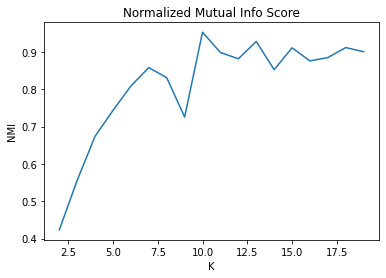

In [23]:
nmi_list = []
for h in range(2, 20):
    dis_mat = np.load("distance_traffic.npy")
    M, C = kMedians(dis_mat, h)
    label_predict = np.zeros(labels.shape)
    #print(C[0])
    for i in range(h):
        label_predict[C[i], 0] = i
    l1 = labels.flatten()
    l2 = label_predict.flatten()
    nmi = normalized_mutual_info_score(l1, l2)
    nmi_list.append(nmi)
    print(nmi)
print('end')
plt.plot(range(2, 20), nmi_list)
plt.xlabel("K")
plt.ylabel("NMI")
plt.title("Normalized Mutual Info Score")
plt.show()

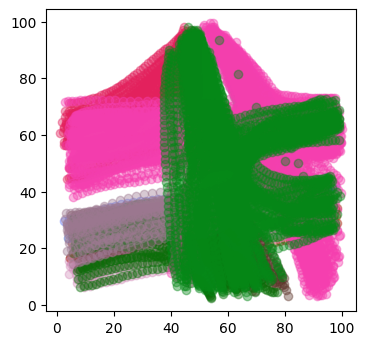

In [30]:
distance_mat=np.load("distance_traffic.npy")
M, C= kMedians(distance_mat, 10) # M - medoids, C - cluster
alph=0.4
fig=plt.figure(figsize=(4,4),dpi=100) 
ax=plt.gca()
label_color=[]
for i in range(20):
    label_color+=[[np.random.random(),np.random.random(),np.random.random(),alph],]
ax.cla()
for label_idx in range(10):
    for t_idx in C[label_idx]:
        ax.scatter(tracks[t_idx][0][0,:], tracks[t_idx][0][1,:], color=label_color[label_idx+1])
plt.show()
fig.savefig("训练着色.png")